<a href="https://colab.research.google.com/github/aMurryFly/Text-Classification-AI-Model-on-COVID-19-Tweets/blob/main/FinalProject_TwittClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project of APIT Course
## Data Analysis and Text Classification AI Model on COVID-19 Tweets

###(Análisis y Procesamiento Inteligente de textos)

**Professor:**
- Octavio Augusto Sánchez Velázquez

**Students:**
- Alfonso Murrieta Villegas
- Edgar Michael Pérez Valdez


# 0. Aspectos generales 


## 0.0 Importación de bibliotecas y recursos para el análisis de datos en la etapa de pre-procesamiento

In [1]:
#Bibliotecas generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

# Para la construcción del módelo
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [2]:
# Azúcar visual 
import warnings
warnings.filterwarnings('ignore')

#Para dar formato a los dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 0.1 Importando  y conociendo el dataset

### 0.1.0 Importando datos 

In [3]:
test=pd.read_csv("/content/DataSet/Corona_NLP_test.csv",encoding='latin1')
train=pd.read_csv("/content/DataSet/Corona_NLP_train.csv",encoding='latin1')

Conociendo nuestros datos para el "test" del futuro módelo

In [4]:
test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
test.shape[0]

3798

Conociendo nuestros datos para el "train" del futuro módelo

In [6]:
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train.shape[0]

41157

### 0.1.1 Relación Train y Test Data

Observando relación del dataset de "train y test"

**NOTA**: Para nuestra futura construcción del modelo de AI emplearemos una relación de 75 / 25 como típica convención 

In [8]:
totalData = train.shape[0] + test.shape[0]
print("Total de datos (filas)", totalData)
print("Relación del train respecto al total: ",train.shape[0]/totalData)
print("Relación del test respecto al total: ",test.shape[0]/totalData)

Total de datos (filas) 44955
Relación del train respecto al total:  0.9155155155155155
Relación del test respecto al total:  0.08448448448448448


### 0.1.2 Valores Nulos

Conociendo valores nulos en el dataset

NOTA: Se unieron los datos previamente para conocer la información global

In [9]:
concData=pd.concat([train,test])

nullValues= concData.isnull().sum().sort_values(ascending=False)
total =concData.shape[0]

percent_missing= (concData.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])

Imprimimos los datos obtenidos tras la concatenación de ambos dataframes

In [10]:
print (loss_data)

               Datos nulos  Porcetaje
Location              9424   0.209632
Sentiment                0   0.000000
OriginalTweet            0   0.000000
TweetAt                  0   0.000000
ScreenName               0   0.000000
UserName                 0   0.000000


**NOTA:** Podemos observar que hay una cantidad considerable de datos nulos en la columna de "location", sin embargo, para nuestro modelo no será necesaria esa información.

### 0.1.3 Relación tweets / usuarios 

Al tomar una muestra lo recomendable es no sesgar la información como puede ser el caso de recopilar la información de una misma fuente, es decir, hacer un muestreo aleatorio

Por lo que a continuación se verifica la realación tweets - usuarios (QUe tantos tweets pertenecen a un usuario)

In [11]:
print('Total de tweets: ', concData.shape[0])
print('Total de usuarios (Sin repetir alguno): ', concData['UserName'].nunique())

Total de tweets:  44955
Total de usuarios (Sin repetir alguno):  44955


**NOTA**: Podemos observar que no existe más de un tweet por usuario

# 1. Análisis de datos y conjeturas

**NOTA**

Para el análisis de datos y la construcción del modelo de AI de clasificación de Tweets fue necesario cambiar la cantidad de etiquetas dentro de la clasificación de tweets 

```python
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
```
a

```python
['Neutral' 'Positive' 'Negative' ]
``` 
Donde los casos "extremos" fueron adjuntados en la etiqueta normal, es decir:

'Extremely Negative', 'Negative' => 'Negative'

'Extremely Positive', 'Positive' => 'Positive'

**Justificación:** 

La primera razón del por qué se hará esta recategorización en las etiquetas de sentimal es debido a la complejidad algoritmica y recursos empleados al usar 3 etiquetas en vez de 5.

Y la segunda razón es que encontramos algo subjetivo el decir que un tweet es "extremadamente positivo" o que solamente es "positivo". 


## 1.1 Reetiquetando

Muestreo de datos antes de reetiquetar los datos

In [12]:
print(concData.Sentiment.value_counts())

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


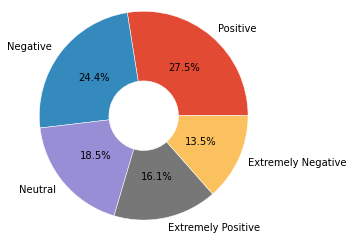

In [13]:
pre_class_allData = concData.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= pre_class_allData.OriginalTweet
labels= pre_class_allData.Sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

Reetiquetando datos

In [14]:
def reetiqueta(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"

In [15]:
dataFrame = concData 
dataFrame['sentiment']= concData['Sentiment'].apply(lambda x:reetiqueta(x))

print("Distribución previa:\n ", concData.Sentiment.value_counts())
print("\n\n\nDistribución actual: \n", dataFrame.sentiment.value_counts())

Distribución previa:
  Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64



Distribución actual: 
 positive    19592
negative    17031
neutral      8332
Name: sentiment, dtype: int64


Nueva distribución de los datos y visualización del nuevo dataFrame

In [16]:
dataFrame.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,negative


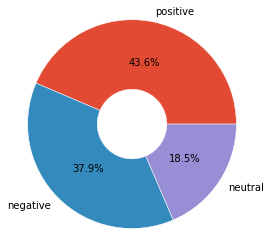

In [17]:
class_allData = dataFrame.groupby('sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= class_allData.OriginalTweet
labels= class_allData.sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

## 1.2 Distribución de datos 

### 1.2.1 Carácteres

Gráficas para conocer la distribución dentro de cada clase en la etiqueta de sentimientos

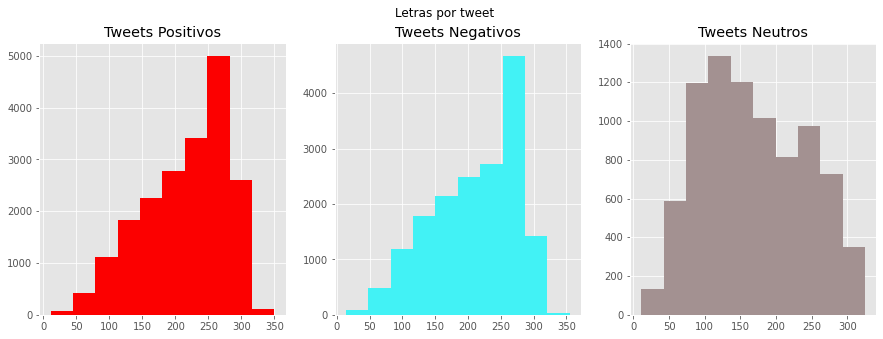

In [18]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_Pos=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.len()
ax1.hist(tweet_Pos,color='#FC0000')
ax1.set_title('Tweets Positivos')

tweet_Neg=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_Neg,color='#42F2F5')
ax2.set_title('Tweets Negativos')

tweet_Null=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_Null,color='#A39191')
ax3.set_title('Tweets Neutros')

fig.suptitle('Letras por tweet')
plt.show()

In [19]:
# Agregando header para medias
#Solo correr una vez
tweet_Pos = tweet_Pos.to_frame('characters') 
tweet_Neg = tweet_Neg.to_frame('characters') 
tweet_Null = tweet_Null.to_frame('characters') 

In [20]:

PosMedia = tweet_Pos['characters'].mean()
NegMedia = tweet_Neg['characters'].mean()
NullMedia = tweet_Null['characters'].mean()

print("Promedio de carácteres en tweets positivos",PosMedia )
print("Promedio de carácteres en tweets negativos",NegMedia )
print("Promedio de caracteres en tweets neutros",NullMedia )

Promedio de carácteres en tweets positivos 215.60090853409554
Promedio de carácteres en tweets negativos 210.87358346544536
Promedio de caracteres en tweets neutros 168.16082573211713


**NOTA:**
Podemos observar a priori que notamos ciertos patrones de asimetría en las respectivas distribuciones, sin embargo, también observamos que el promedio de carácteres en los tweets neutros suele ser mucho menor respecto a la cantidad usada en los tweets positivos y negativos

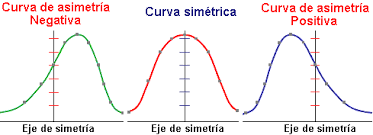

Cabe destacar que este tipo de información es útil sobre todo para crear nuestro futuro modelo de IA 

### 1.2.2 Distribución y promedio de palabras 


(0.0, 20.0)

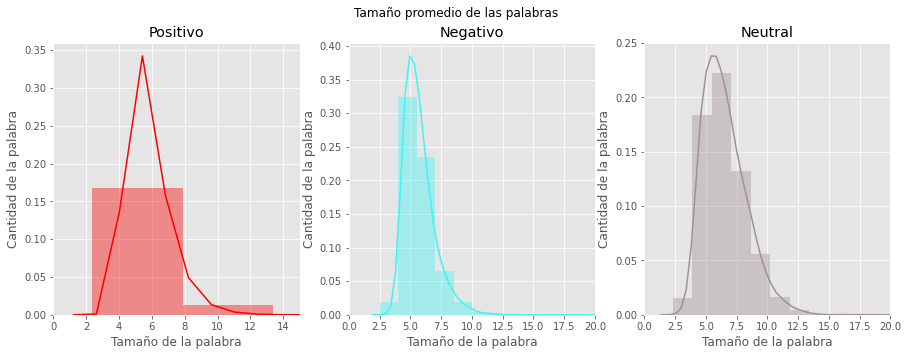

In [21]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Tamaño promedio de las palabras \n')

Pos_words=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Pos_words.map(lambda x: np.mean(x)),ax=ax1,color='#FC0000')
ax1.set_title('Positivo')
ax1.set_xlabel('Tamaño de la palabra')
ax1.set_ylabel('Cantidad de la palabra')
ax1.set_xlim(0,15)

Neg_word=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Neg_word.map(lambda x: np.mean(x)),ax=ax2,color='#42F2F5')
ax2.set_title('Negativo')
ax2.set_xlabel('Tamaño de la palabra')
ax2.set_ylabel('Cantidad de la palabra')
ax2.set_xlim(0,20)

Null_word=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Null_word.map(lambda x: np.mean(x)),ax=ax3,color='#A39191')
ax3.set_title('Neutral')
ax3.set_xlabel('Tamaño de la palabra')
ax3.set_ylabel('Cantidad de la palabra')
ax3.set_xlim(0,20)

**NOTA 1:**

A priori podemos observar patrones como el que los mensajes neutros de manera general manejan palabras mucho más extensas en cantidad de letras, mientras que los mensajes positivos suelen tener una menor cantidad de letras por palabras,es decir, los mensajes motivadores suelen ser pequeños (Para reafirmar esta hipótesis haremos uso de wordclouds como forma de visualización de las palabras)



**NOTA 2:**

Al igual que en el apartado anterior podemos observar un comportamiento relativamente similar en los tweets neutrales, donde la media de la distribución de las palabras tiende a ser menor respectos a los tweets positivos y negativos.

Por otro lado, podemos llegar a observar nuevamente umna desviación de datos hacia la izquierda , es decir una simetría negativa que probablemente se deba a factores como la cantidad de palabras/carácteres que se puede usar en Twitter 

# 2 Limpieza de datos 

## 2.1 Stopwords 



Función para crear el corpus con el que posteriormente se hará el modelo de AI de clasificación

In [22]:
def create_corpus(target):
    corpus=[]
    
    for x in dataFrame[dataFrame['Sentiment']==target ]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Importanción de bibliotecas y recursos para *tokinaze* y para el uso de NLTK (Previo a la creación del modelo de inteligencia artificial)


In [23]:
import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NOTA**
Haremos uso de *stopwords* para poder omitir las palabras más comúnes del inglés que sin duda no serán necesarias para sacar los patrones de comportamiento de los tweets

**Stopwords** = Palabra comúnmente usada tal como "él, "un" que al ser conectores son omitidos por no aportar información en análisis concretos de textos


In [24]:
np.array(stop)

array({'no', "hadn't", 'an', 'very', 'if', 'your', 'out', 'ma', 'was', 'i', 'did', 'too', 'been', 'aren', 'why', 'through', "won't", "that'll", 'ourselves', "doesn't", 'who', 'here', 'himself', 'is', 'just', 'them', 'once', 'isn', 'couldn', 'over', 'needn', 'm', 'against', "don't", "she's", 'those', 'itself', 'both', 'with', 'they', 'which', 'above', 'll', 'ain', "you'll", 'yours', 'mightn', "isn't", "aren't", 'of', 'nor', 'o', 'than', 'weren', 'have', 'doesn', 'to', 'or', 'there', 'at', 'its', "wouldn't", 'when', 'how', 'below', 'on', 'same', 'up', 'hadn', 'hers', 'under', 'any', 'didn', 'ours', 't', "couldn't", 'my', "hasn't", 'themselves', "should've", 'wouldn', 'more', 'his', 'these', 'had', 'd', 'the', 'our', 'were', 'down', 'should', 'but', 'again', "didn't", 'wasn', 'not', 'can', 'few', "haven't", 'before', 'between', 'shan', 'where', 'am', 'own', 'has', "you've", 'their', 'doing', 'some', "mightn't", "shouldn't", 'won', 'her', 'we', 'yourself', 'such', 'most', "wasn't", 'it', '

## 2.2 Limpieza de datos y separación de datos respecto al sentimiento

Función para remover links

In [25]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

Función para hacer todas las letras en minúsculas

In [26]:
def turn_lower(text):
    low_text= text.lower()
    return low_text

Función para remover stopwords

In [27]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

LLamada de todas las funciones en el dataFrame

In [28]:
dataFrame['text_new']=dataFrame['OriginalTweet'].apply(lambda x:remove_urls(x))
dataFrame['OriginalTweet']=dataFrame['text_new'].apply(lambda x:remove_stopwords(x))
dataFrame['text_new']=dataFrame['OriginalTweet'].apply(lambda x:turn_lower(x))
dataFrame.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,text_new
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv,Neutral,neutral,@menyrbie @phil_gahan @chrisitv
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,Positive,positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,Positive,positive,coronavirus australia: woolworths give elderly...
3,3802,48754,NaN,16-03-2020,"My food stock one empty... PLEASE, panic, THER...",Positive,positive,"my food stock one empty... please, panic, ther..."
4,3803,48755,NaN,16-03-2020,"Me, ready go supermarket #COVID19 outbreak. No...",Extremely Negative,negative,"me, ready go supermarket #covid19 outbreak. no..."


Funciones para remover hastags y etiquetados 

In [29]:
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

Observamos como ha quedado el dataframe tras la limpieza de los tweets

In [30]:
dataFrame['OriginalTweet']=dataFrame['text_new'].apply(lambda x:remove_hash(x))
dataFrame['text_new']=dataFrame['OriginalTweet'].apply(lambda x:remove_mention(x))
dataFrame[10:15]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,text_new
10,3809,48761,"Makati, Manila",16-03-2020,"all month crowding supermarkets restaurants, h...",Neutral,neutral,"all month crowding supermarkets restaurants, h..."
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"due covid-19 situation, increased demand food ...",Extremely Positive,positive,"due covid-19 situation, increased demand food ..."
12,3811,48763,Horningsea,16-03-2020,caring community. letâs all look less capabl...,Extremely Positive,positive,caring community. letâs all look less capabl...
13,3812,48764,"Chicago, IL",16-03-2020,"me: i need stock food, i'll amazon deliver wha...",Positive,positive,"me: i need stock food, i'll amazon deliver wha..."
14,3813,48765,NaN,16-03-2020,adara releases covid-19 resource center travel...,Positive,positive,adara releases covid-19 resource center travel...


Válidamos si no hay algún tweet que se haya vuelto nulo respecto al contenido del tweet que ahora se encuentra en la columna 'text_new'

In [31]:
nullValues= dataFrame.isnull().sum().sort_values(ascending=False)
total =dataFrame.shape[0]

percent_missing= (dataFrame.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])
print(loss_data)

               Datos nulos  Porcetaje
Location              9424   0.209632
text_new                 0   0.000000
sentiment                0   0.000000
Sentiment                0   0.000000
OriginalTweet            0   0.000000
TweetAt                  0   0.000000
ScreenName               0   0.000000
UserName                 0   0.000000


In [32]:
dataFramePos = dataFrame[dataFrame["sentiment"]=="positive"]
dataFrameNeg = dataFrame[dataFrame["sentiment"]=="negative"]
dataFrameNeu = dataFrame[dataFrame["sentiment"]=="neutral"]
dataFramePos.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,text_new
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia: woolworths give elderly...,Positive,positive,coronavirus australia: woolworths give elderly...
3,3802,48754,NaN,16-03-2020,"my food stock one empty... please, panic, ther...",Positive,positive,"my food stock one empty... please, panic, ther..."


## 2.3 WordCloud y visualización de palabras por sentimientos

In [33]:
def bagWords(x):
  comment_words = '' 
  stopwords = set(STOPWORDS) 

  for val in x.text_new: 
      val = str(val) 
      tokens = val.split() # split the value 
      comment_words += " ".join(tokens)+" "
  return comment_words

**Word Cloud del DataFrame Positivo**

Se pueden observar las palabras más comúnes en los tweets positivos

In [34]:
bagwordsvar = bagWords(dataFramePos)
bagwordsvar

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order coronavirus australia: woolworths give elderly, disabled dedicated shopping hours amid covid-19 outbreak my food stock one empty... please, panic, there will be enough food for everyone take need. stay calm, stay safe. as news regionâ\x92s first confirmed covid-19 case came sullivan county last week, people flocked area stores purchase cleaning supplies, hand sanitizer, food, toilet paper goods, reports cashier grocery store sharing insights to prove credibility commented "i\'m civics class i know i\'m talking about". due covid-19 retail store classroom atlanta open walk-in business classes next two weeks, beginning monday, march 16. we continue process online phone orders normal! thank understanding! due covid-19 situation, increased demand food products. the wait time may longer online ord

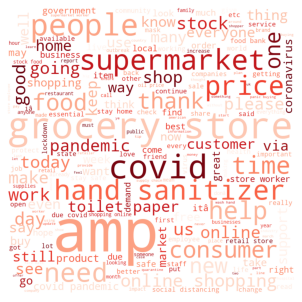

In [44]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                min_font_size = 10).generate(bagwordsvar)
  
# plot the WordCloud image                       
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()   

**Word Cloud del DataFrame Negativos**

Se pueden observar las palabras más comúnes en los tweets negativos

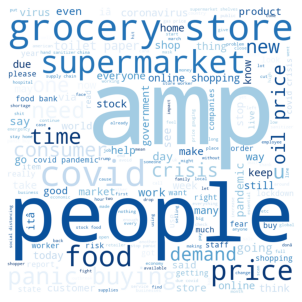

In [39]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Blues",
                min_font_size = 10).generate(bagWords(dataFrameNeg))
  
# plot the WordCloud image                       
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

**Word Cloud del DataFrame Neutro**

Se pueden observar las palabras más comúnes en los tweets neutro

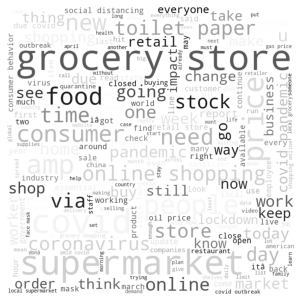

In [41]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                min_font_size = 10).generate(bagWords(dataFrameNeu))
  
# plot the WordCloud image                       
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

# 2. Contruyendo el modelo de IA para clasificar
 